2


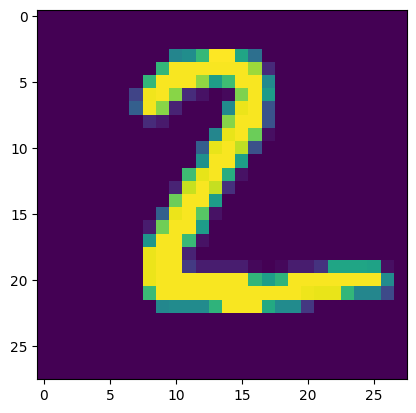

In [26]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

train_images_path = 'dataset/train-images.idx3-ubyte'
train_labels_path = 'dataset/train-labels.idx1-ubyte'
test_images_path = 'dataset/t10k-images.idx3-ubyte'
test_labels_path = 'dataset/t10k-labels.idx1-ubyte'

# Carregar o conjunto de treino para avaliação
arr_images_train = idx2numpy.convert_from_file(train_images_path)
arr_labels_train = idx2numpy.convert_from_file(train_labels_path).astype(int)

# Carregar o conjunto de teste para avaliação
arr_images_test = idx2numpy.convert_from_file(test_images_path)
arr_labels_test = idx2numpy.convert_from_file(test_labels_path).astype(int)

example = np.asarray(arr_images_test[1]).squeeze()
plt.imshow(example)

print(arr_labels_test[1])

In [27]:
print(arr_images_train.shape, arr_labels_train.shape)

(60000, 28, 28) (60000,)


In [28]:
# Transformar as imagens em vetores e normalizá-las
X_train = arr_images_train.reshape(arr_images_train.shape[0], -1)
X_test = arr_images_test.reshape(arr_images_test.shape[0], -1)

# Adicionar uma coluna de 1s para considerar o termo de bias (intercept) no modelo linear
X_train = np.column_stack((X_train, np.ones(X_train.shape[0])))
X_test = np.column_stack((X_test, np.ones(X_test.shape[0])))

# Colocar y em formato de vetor (one hot)
def one_hot_convert(vec):
    matrix = []
    for idx in vec:
      m = np.zeros((10, 1))
      m[idx] = 1
      matrix.append(m)
    return np.array(matrix)

y_train = one_hot_convert(arr_labels_train).reshape(arr_labels_train.shape[0], -1)
y_test = arr_labels_test.reshape(arr_labels_test.shape[0], -1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 785) (60000, 10)
(10000, 785) (10000, 1)


In [29]:
# Funções de ativação para o neurônio
def activate_functions(type, matrix):
    if type == 'sigmoid':
        return 1 / (1 + np.exp(-matrix))
    elif type == 'softmax':
        exp_matrix = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
        return exp_matrix / np.sum(exp_matrix, axis=1, keepdims=True)   
    elif type == 'tanh':
        return np.tanh(matrix)

# Função de treino do MLP
def mlp_train(X, y, n_neurons_hlayer, epochs, l_rate, criteria):
    n_classes = y.shape[1]
    n_features = X.shape[1]

    w_input = np.random.randn(n_features, n_neurons_hlayer) * 0.1
    w_output = np.random.randn(n_neurons_hlayer, n_classes) * 0.1

    bias_input = np.random.randn(n_neurons_hlayer, 1) * 0.5
    bias_output = np.random.randn(n_classes, 1) * 0.5

    for epoch in range(epochs):
        
        # Forward
        Zin = (X @ w_input) + bias_input.T
        result_in = activate_functions('sigmoid', Zin)

        Zout = (result_in @ w_output) + bias_output.T
        result_out = activate_functions('softmax', Zout)

        # Backpropagation
        error_out = result_out - y
        grad_out = error_out / len(X)

        error_in = grad_out @ w_output.T
        grad_in = error_in * result_in * (1 - result_in)

        # Ajustar os pesos e os viéses
        w_input -= l_rate * np.dot(X.T, grad_in)
        w_output -= l_rate * np.dot(result_in.T, grad_out)

        bias_input -= l_rate * np.sum(grad_in, axis=0, keepdims=True).T
        bias_output -= l_rate * np.sum(grad_out, axis=0, keepdims=True).T

        if epoch == 0:
            loss = np.mean((y - result_out)**2)
            print('Initial Epoch: {}, loss: {}'.format(epoch, loss))
            best_loss = loss
            
        if epoch != 0 and epoch % 5 == 0:
            loss = np.mean((y - result_out)**2)
            print('Epoch: {}, loss: {}'.format(epoch, loss))

            if loss < best_loss:
                best_loss = loss
                wait = 0
            else: wait += 1

            if wait >= criteria:
                print('Final Epoch (loss stopped): {}, loss: {}'.format(epoch, loss))
                return w_input, w_output, bias_input, bias_output

    loss = np.mean((y - result_out)**2)
    print('Last Epoch: {}, loss: {}'.format(epoch+1, loss))
                                      
    return w_input, w_output, bias_input, bias_output

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

def random_search(X, y):
    mlp = MLPClassifier(activation='logistic', learning_rate_init=0.01) # Mantendo configurações do MLP - l_rate, função de ativação sigmoid, etc

    params_search = {"hidden_layer_sizes": list(np.arange(2,500))}
    
    search = RandomizedSearchCV(mlp, param_distributions=params_search, n_jobs=-1, cv=3, verbose=5) # Busca do melhor numero de neuronios da camada
    search.fit(X, y)
    best = search.best_params_['hidden_layer_sizes']
    
    return best

n_neurons = random_search(X_train, y_train)
print("Neurons in hidden layer: ", n_neurons)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ............hidden_layer_sizes=408;, score=0.860 total time=17.6min
[CV 3/3] END .............hidden_layer_sizes=44;, score=0.775 total time= 1.8min
[CV 2/3] END .............hidden_layer_sizes=74;, score=0.801 total time= 1.5min
[CV 1/3] END ............hidden_layer_sizes=457;, score=0.837 total time= 9.0min
[CV 1/3] END ............hidden_layer_sizes=112;, score=0.802 total time= 2.4min
[CV 1/3] END ............hidden_layer_sizes=499;, score=0.842 total time=18.9min
[CV 2/3] END .............hidden_layer_sizes=87;, score=0.808 total time= 1.9min
[CV 3/3] END ............hidden_layer_sizes=408;, score=0.849 total time=12.4min
[CV 3/3] END ............hidden_layer_sizes=402;, score=0.827 total time= 7.4min
[CV 2/3] END ............hidden_layer_sizes=457;, score=0.863 total time=25.1min
[CV 3/3] END ............hidden_layer_sizes=337;, score=0.826 total time= 6.2min
[CV 3/3] END .............hidden_layer_sizes=87;

In [34]:
w_input, w_output, bias_input, bias_output = mlp_train(X_train, y_train, n_neurons, epochs=5000, l_rate=0.1, criteria=15)

/tmp/ipykernel_6471/752231831.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-matrix))


Initial Epoch: 0, loss: 0.10557864528982763
Epoch: 5, loss: 0.07356137036912765
Epoch: 10, loss: 0.05763387692442999
Epoch: 15, loss: 0.04798407035531647
Epoch: 20, loss: 0.041787149781363636
Epoch: 25, loss: 0.03754492663315067
Epoch: 30, loss: 0.03444376521473046
Epoch: 35, loss: 0.03200539821891574
Epoch: 40, loss: 0.03008941360352721
Epoch: 45, loss: 0.028479245406458024
Epoch: 50, loss: 0.02716211428839557
Epoch: 55, loss: 0.025995063261963564
Epoch: 60, loss: 0.025024436251762348
Epoch: 65, loss: 0.024135216018165973
Epoch: 70, loss: 0.023405344576328722
Epoch: 75, loss: 0.022700918232069205
Epoch: 80, loss: 0.022121682911702707
Epoch: 85, loss: 0.021547271320595824
Epoch: 90, loss: 0.021077825156549792
Epoch: 95, loss: 0.02056414883272983
Epoch: 100, loss: 0.02016781890301798
Epoch: 105, loss: 0.019750911056213988
Epoch: 110, loss: 0.019413788649893817
Epoch: 115, loss: 0.019037768509988857
Epoch: 120, loss: 0.018752076508609224
Epoch: 125, loss: 0.01842106568413397
Epoch: 130, 

In [35]:
# Função de predição do MLP
def mlp_predict(X, w_in, w_out, bias_in, bias_out):
    # Forward
    Zin = (X @ w_in) + bias_in.T
    result_in = activate_functions('sigmoid', Zin)

    Zout = (result_in @ w_out) + bias_out.T
    result_out = activate_functions('softmax', Zout)

    # Converte as saídas para as classes preditas (0 a 9) usando a função argmax
    # A classe predita será o índice do valor máximo em cada linha
    print(result_out)
    classe = np.argmax(result_out, axis=1)
    print(classe.shape)

    return np.expand_dims(classe, axis=1)

# Realizar a predição no conjunto de teste
y_pred_test = mlp_predict(X_test, w_input, w_output, bias_input, bias_output)

print(y_pred_test.shape)
print(y_test.shape)

(10000,)
(10000, 1)
(10000, 1)


/tmp/ipykernel_6471/752231831.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-matrix))


In [36]:
# Avaliar o desempenho do classificador
error = (10000 - sum(y_pred_test == y_test)) / 10000 
print("Error rate: {}".format(error[0]))

Error rate: 0.0684
